In [226]:
import autograd.numpy as np
import openpyxl as xl
import sympy as sp
import matplotlib.pyplot as plt

from sympy.abc import x
from sympy.utilities.lambdify import lambdify, implemented_function
from autograd import grad, jacobian


Function to Fit:
$$
S(\nu - \nu_0) = S(\infty)\left[1-\frac{C(\Delta\nu)^2}{(\nu-\nu_0)^2+(\Delta\nu/2)^2}\right]
$$
Turn it into:
$$
g(x) = a_1 \left[1-\frac{a_2 \cdot a_3}{(x-a_4)^2+a_3}\right]
$$
Least square:
$$
\chi^2 = (y_i-g(x_i))^2
$$

In [227]:
'''Import data and get the length of data'''
x = []
y = []
wb = xl.load_workbook('D:\getdata\single_peak_cwodmr\data2.xlsx')
sheet = wb['Sheet1']

for row in range(1, sheet.max_row + 1):
    x.append(sheet.cell(row,1).value)
for row in range(1, sheet.max_row + 1):
    y.append(sheet.cell(row,2).value)

x_data =np.array(x)
y_data =np.array(y)
n = len(x_data)

In [228]:
'''Define least square function'''
def g(x,a):
    g = a[0]*(1-a[1]*a[2]/((x-a[3])**2+a[2]))
    return g

def chi_square(a):
    chi_square = 0
    for i in range(n):
        chi_square += (y_data[i] - g(x_data[i],a))^2
    return chi_square

In [229]:
'''Take partial derivatives by sympy'''
#Partial derivatives on a3
x, a, b, c, d = sp.symbols('x a b c d')
f = a*(1-b*c/((x-d)**2+c))
f

a*(-b*c/(c + (-d + x)**2) + 1)

In [230]:
'''Take partial derivatives'''
f_a = sp.diff(f,a)
f_b = sp.diff(f,b)
f_c = sp.diff(f,c)
f_d = sp.diff(f,d)
print(f_a)
print(f_b)
print(f_c)
print(f_d)
lam_f_a = lambdify([x, b, c, d], f_a)
lam_f_b = lambdify([x, a, c, d], f_b)
lam_f_c = lambdify([x, a, b, c, d], f_c)
lam_f_d = lambdify([x, a, b, c, d], f_d)

# def df_da(x_data,a):
#     df_da = f_a.subs([(x,x_data),(a,a[0]),(b,a[1]),(c,a[2]),(d,a[3])]).evalf()
#     return df_da

# def df_db(x,a):
#     df_db = f_b.subs([(x,x_data),(a,a[0]),(b,a[1]),(c,a[2]),(d,a[3])]).evalf()
#     return df_db

# def df_dc(x,a):
#     df_dc = f_c.subs([(x,x_data),(a,a[0]),(b,a[1]),(c,a[2]),(d,a[3])]).evalf()
#     return df_dc

# def df_dd(x,a):
#     df_dd = f_d.subs([(x,x_data),(a,a[0]),(b,a[1]),(c,a[2]),(d,a[3])]).evalf()
#     return df_dd

-b*c/(c + (-d + x)**2) + 1
-a*c/(c + (-d + x)**2)
a*(b*c/(c + (-d + x)**2)**2 - b/(c + (-d + x)**2))
-a*b*c*(-2*d + 2*x)/(c + (-d + x)**2)**2


In [231]:
'''Four functions that need to be fitted through Newton Raphson'''
def func1(a):

    diff = 0
    for i in range(n):
        diff += (y_data[i] - g(x_data[i],a))*lam_f_a(x=x_data[i], b=a[1], c=a[2], d=a[3])
   
    return diff


def func2(a):

    diff = 0
    for i in range(n):
        diff += (y_data[i] - g(x_data[i],a))*lam_f_b(x=x_data[i], a=a[0], c=a[2], d=a[3])
    
    return diff

def func3(a):

    diff = 0
    for i in range(n):
        diff += (y_data[i] - g(x_data[i],a))*lam_f_c(x=x_data[i], a=a[0], b=a[1], c=a[2], d=a[3])
    
    return diff

def func4(a):

    diff = 0
    for i in range(n):
        diff += (y_data[i] - g(x_data[i],a))*lam_f_d(x=x_data[i], a=a[0], b=a[1], c=a[2], d=a[3])

    return diff

In [232]:
'''Take Jacobian'''
jac_func1 = jacobian(func1)
jac_func2 = jacobian(func2)
jac_func3 = jacobian(func3)
jac_func4 = jacobian(func4)

In [236]:
i = 0
error = 100
tol = 1e-8
maxiter = 1000
M = 4
N = 4

x_0 = np.array([1.,0.012,0.0001,2.654], dtype=float).reshape(N,1)
fun_evaluate = np.array([func1(x_0),func2(x_0),func3(x_0),func4(x_0)]).reshape(M,1)

er = []
iter = []
while np.any(error > tol) and i < maxiter:
    
    func_evaluate = np.array([func1(x_0),func2(x_0),func3(x_0),func4(x_0)]).reshape(M,1)
    flat_x_0 = x_0.flatten()
    jac = np.array([jac_func1(flat_x_0),jac_func2(flat_x_0),jac_func3(flat_x_0),jac_func4(flat_x_0)])
    jac.reshape(M,N)

    x_new = x_0 - np.linalg.inv(jac)@func_evaluate
    error = (abs(x_new - x_0)/x_0)
    
    x_0 = x_new

    print(i)
    print(error)
    print('-'*10)

    er.append(error)
    iter.append(i)
    
    i += 1
    
print('The Solution is: {}'.format(x_new))
print("LHS of function 1: {}".format(np.around(func1(x_new),12)))
print("LHS of function 2: {}".format(np.around(func2(x_new),12)))
print("LHS of function 3: {}".format(np.around(func3(x_new),12)))
print("LHS of function 4: {}".format(np.around(func4(x_new),12)))

0
[[1.32649949e-03]
 [8.23120040e-02]
 [6.54515365e-01]
 [5.99396334e-06]]
----------
1
[[2.87214086e-02]
 [4.37246750e-01]
 [2.15924440e+01]
 [4.72414004e-03]]
----------
2
[[ 6.32963260e-02]
 [ 1.18937952e+00]
 [-2.18775615e-02]
 [ 4.73414662e-04]]
----------
3
[[ 6.71483975e-02]
 [ 2.18119449e+00]
 [-8.71164445e-02]
 [ 1.72322875e-03]]
----------
4
[[ 3.52877403e-02]
 [ 8.63543187e-01]
 [-1.38357329e-02]
 [ 1.26740650e-05]]
----------
5
[[  0.86659118]
 [ 27.79405399]
 [-32.42989584]
 [  0.3380944 ]]
----------
6
[[0.47464652]
 [0.47656054]
 [0.53355565]
 [0.13371996]]
----------
7
[[1.75022558e-04]
 [2.71741909e-01]
 [4.31488882e-01]
 [5.20765282e-02]]
----------
8
[[0.00482534]
 [0.39287523]
 [0.57414417]
 [0.08203795]]
----------
9
[[0.01029422]
 [0.05811508]
 [0.06874578]
 [0.01447154]]
----------
10
[[0.00477134]
 [0.01011072]
 [0.01336121]
 [0.01547123]]
----------
11
[[0.00679608]
 [0.0496441 ]
 [0.06300809]
 [0.03141445]]
----------
12
[[0.0035904 ]
 [0.00667158]
 [0.0082255

LinAlgError: Singular matrix

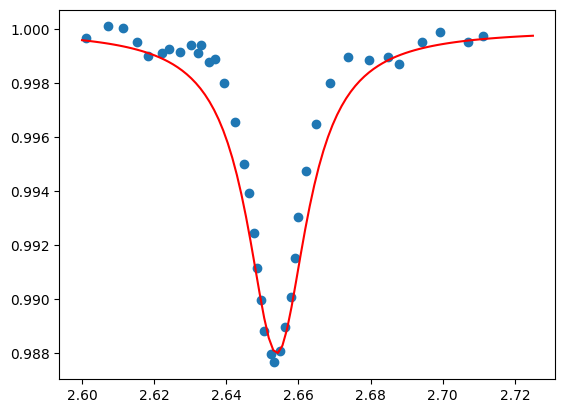

In [237]:
plt.scatter(x_data,y_data)
x = np.linspace(2.6,2.725,100)
a = [1.,0.012,0.0001,2.654]
y = g(x,a)
plt.plot(x,y,'r')
plt.show()